In [1]:
import os
import json
import pickle
import subprocess
import xgboost
from base import ModelHelper

%load_ext autoreload
%autoreload 2

In [2]:
model_helper = ModelHelper("./categorical_only", "categorical_model")
model_helper

Model Folder = ./categorical_only
Metadata Folder = ./categorical_only/metadata
Path to data = ./raw-data/full_data.gz
Path to test data = ./raw-data/test_labelled.gz
Path to evaluation folder = ./categorical_only/evaluation
Seed = 1

In [3]:
df = model_helper.prepare_data(model_helper.path_to_full_data)
test = model_helper.prepare_data(model_helper.path_to_test_data)

In [4]:
! cat ./raw-data/feature_names.txt | grep 'symbolic'

protocol_type: symbolic.
service: symbolic.
flag: symbolic.
land: symbolic.
logged_in: symbolic.
is_host_login: symbolic.
is_guest_login: symbolic.


In [5]:
process = subprocess.Popen("cat ./raw-data/feature_names.txt | grep 'symbolic'",
                           shell=True,
                           stdout=subprocess.PIPE)
process.wait()
stdout = process.stdout.read().decode().strip('\n').split('\n')
symbolic_cols = [feature.split(':')[0] for feature in stdout]

In [6]:
symbolic_cols

['protocol_type',
 'service',
 'flag',
 'land',
 'logged_in',
 'is_host_login',
 'is_guest_login']

In [7]:
categorical_features = [col for col in df.columns
                        if col in symbolic_cols or any([feature in col for feature in symbolic_cols])]

In [8]:
df = df[[*categorical_features, 'target']]
test = test[[*categorical_features, 'target']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074992 entries, 0 to 1074991
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype
---  ------              --------------    -----
 0   service             1074992 non-null  int64
 1   land                1074992 non-null  int64
 2   logged_in           1074992 non-null  int64
 3   is_host_login       1074992 non-null  int64
 4   is_guest_login      1074992 non-null  int64
 5   protocol_type_icmp  1074992 non-null  uint8
 6   protocol_type_tcp   1074992 non-null  uint8
 7   protocol_type_udp   1074992 non-null  uint8
 8   flag_OTH            1074992 non-null  uint8
 9   flag_REJ            1074992 non-null  uint8
 10  flag_RSTO           1074992 non-null  uint8
 11  flag_RSTOS0         1074992 non-null  uint8
 12  flag_RSTR           1074992 non-null  uint8
 13  flag_S0             1074992 non-null  uint8
 14  flag_S1             1074992 non-null  uint8
 15  flag_S2             1074992 non-null  uint8
 16  

In [10]:
X_train = df[[col for col in df.columns if col != 'target']]
y_train = df['target']
X_test = test[[col for col in test.columns if col != 'target']]
y_test = test['target']

In [11]:
xgb_model = xgboost.XGBClassifier(random_state=model_helper.seed)

In [12]:
best_params = model_helper.random_grid_search(
    X_train, y_train,
    model=xgb_model,
    n_iter=25
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 3

In [13]:
best_params

{'subsample': 0.5,
 'n_estimators': 75,
 'max_depth': 2,
 'learning_rate': 0.4,
 'gamma': 0}

In [15]:
xgb_model = xgboost.XGBClassifier(**best_params, random_state=model_helper.seed)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.02844	validation_1-error:0.08964
[1]	validation_0-error:0.01590	validation_1-error:0.09403
[2]	validation_0-error:0.01590	validation_1-error:0.09403
[3]	validation_0-error:0.01590	validation_1-error:0.09403
[4]	validation_0-error:0.01590	validation_1-error:0.09403
[5]	validation_0-error:0.01854	validation_1-error:0.09462
[6]	validation_0-error:0.01854	validation_1-error:0.09462
[7]	validation_0-error:0.01839	validation_1-error:0.09640
[8]	validation_0-error:0.01839	validation_1-error:0.09640
[9]	validation_0-error:0.01027	validation_1-error:0.08218
[10]	validation_0-error:0.01291	validation_1-error:0.08277
[11]	validation_0-error:0.01028	validation_1-error:0.08037
[12]	validation_0-error:0.01028	validation_1-error:0.08037
[13]	validation_0-error:0.01028	validation_1-error:0.08037
[14]	validation_0-error:0.00869	validation_1-error:0.07577
[15]	validation_0-error:0.00775	validation_1-error:0.07279
[16]	validation_0-error:0.00741	validation_1-error:0.07117
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
model_helper.model = xgb_model
model_helper.save_model()

              precision    recall  f1-score   support

      normal       0.91      0.99      0.95     47913
      attack       0.99      0.84      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291



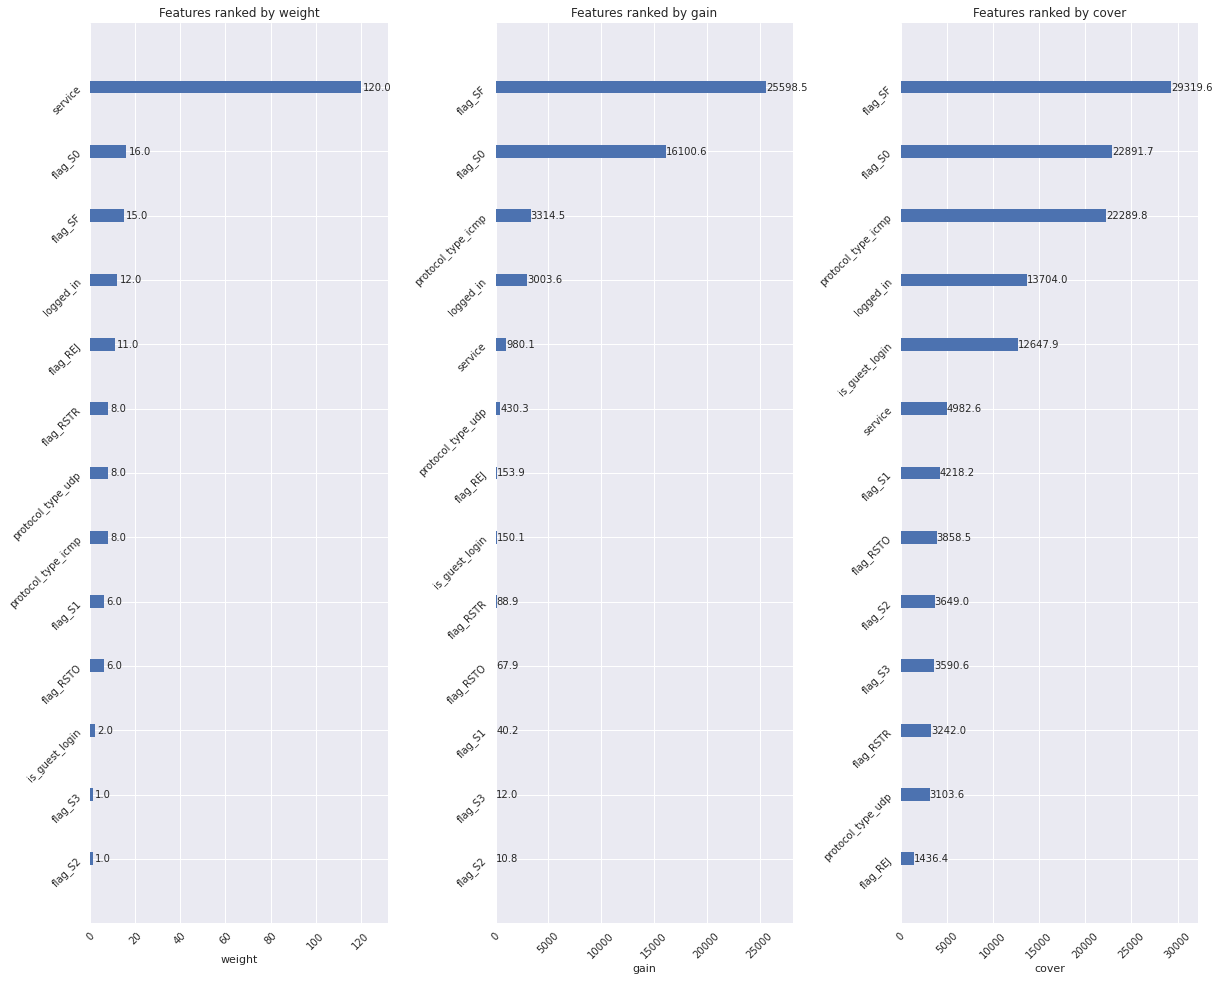

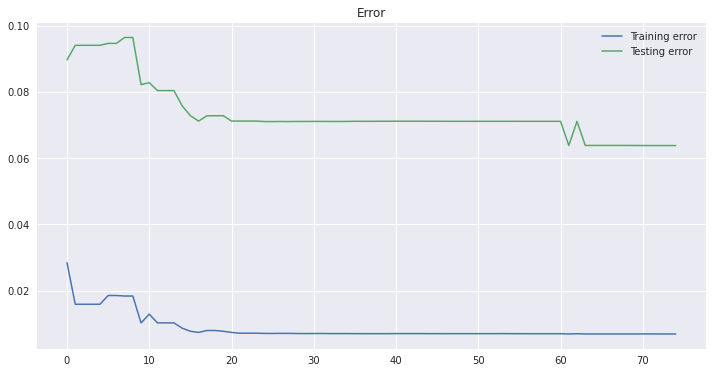

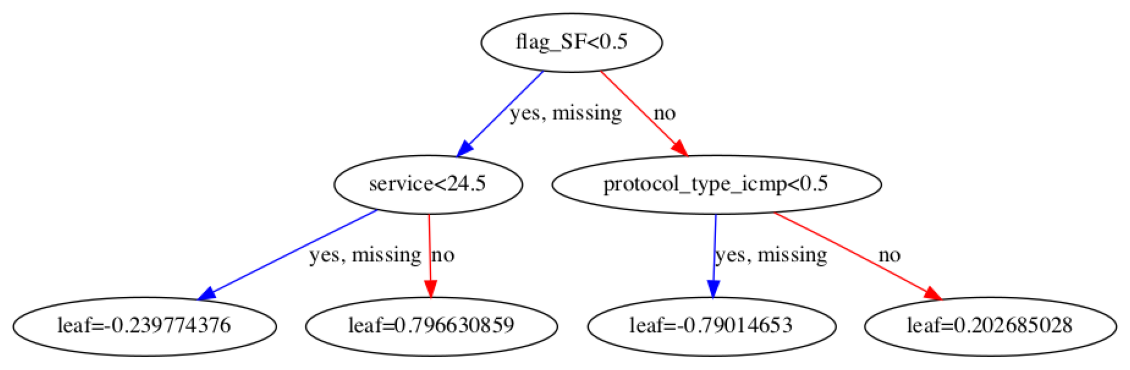

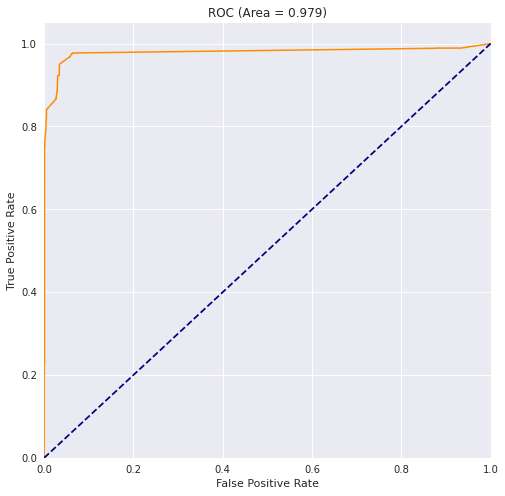

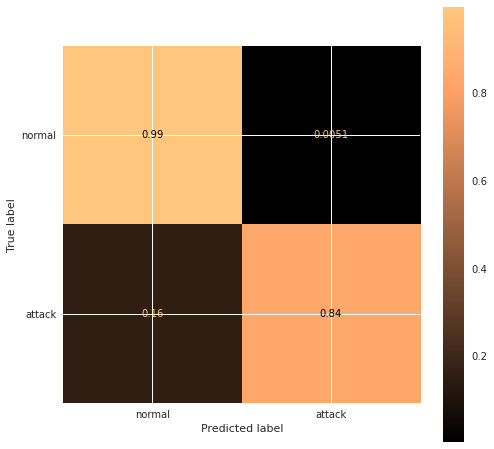

In [17]:
evaluation = model_helper.evaluate_model(X_test, y_test)

In [18]:
evaluation

{'accuracy': 0.9362150832567828,
 'balanced_accuracy': 0.8353739863989786,
 'prfs': {'precision': {'normal': 0.9104642945816384,
   'attack': 0.9902935985881598},
  'recall': {'normal': 0.9949491787197629, 'attack': 0.8404248076792158},
  'f1_score': {'normal': 0.9508337322482846, 'attack': 0.9092248204750507},
  'support': {'normal': 47913.0, 'attack': 29378.0}},
 'test_target_proportions': {False: 0.6199039991719605,
  True: 0.38009600082803946},
 'model_params': {'objective': 'binary:logistic',
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 0,
  'gpu_id': -1,
  'importance_type': 'gain',
  'interaction_constraints': '',
  'learning_rate': 0.4,
  'max_delta_step': 0,
  'max_depth': 2,
  'min_child_weight': 1,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 75,
  'n_jobs': 0,
  'num_parallel_tree': 1,
  'random_state': 1,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,